<a href="https://colab.research.google.com/github/ArghyaPal/MR_SOTA/blob/main/Copy_of_ConvDecoder_for_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI reconstruction from multicoil data using un-trained neural networks

In [1]:
### import helpers
!git clone https://github.com/MLI-lab/ConvDecoder.git
from ConvDecoder.demo_helper.helpers import *

fatal: destination path 'ConvDecoder' already exists and is not an empty directory.


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore')

import h5py
import time
import copy

import torch
import torch.optim
from torch.autograd import Variable
from skimage.measure import compare_ssim

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print("num GPUs",torch.cuda.device_count())

num GPUs 1


# Loading the data

The following cell clones the data from a remote url. The data consists of a single validation image from the [fastMRI dataset](https://arxiv.org/abs/1811.08839).

In [3]:
import urllib.request as urll
proxy_handler = urll.ProxyHandler({})
opener = urll.build_opener(proxy_handler)
urll.install_opener(opener)
data_url =  'https://rice.box.com/shared/static/y1tcaa0eo62ie3lszrkamqivdvirx1x3.h5'
req = urll.Request(data_url)
r = opener.open(req)
result = r.read()

### store the downloaded data in the session directory
filename = 'file1339.h5'
with open(filename, 'wb') as f:
  f.write(result)

The data contains an entire volume of data, each volume consists of slices. We reconstruct the middle slice, which is selected in the following, and plotted:

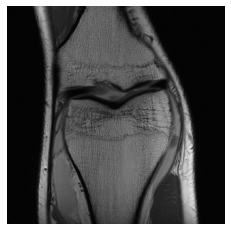

In [4]:
### load the data
f = h5py.File(filename, 'r') # contains a kspace measurement f['kspace'] and rss reconstruction f['reconstruction_rss']


# The f has 3 columns
# ['ismrmrd_header', 'kspace', 'reconstruction_rss']
# kspace: (33, 15, 640, 368)                         <-- 33 batch size, 15 receiving coils
# reconstruction_rss: (33, 320, 320)                 <-- 33 is the batch size


## K space data
slicenu = f["kspace"].shape[0]//2                   # 33/2 = 16, shape[0] is 33
slice_ksp = f['kspace'][slicenu]                    # 15, 640, 368 <-- 15 receiving coils
# Convert complex numpy to torch tensor
data = slice_ksp.copy()
data = np.stack((data.real, data.imag), axis=-1)    # 15, 640, 368, 2 <-- 2 is for the real and imaginary 

# I am artificially making it single receeiver coil
slice_ksp_torchtensor = torch.from_numpy(data)


# Corresponding MR Image
orig = f["reconstruction_rss"][slicenu]             # 320, 320
plt.imshow(orig,'gray')
plt.axis('off')
plt.show()

<a name='funcs'></a>
# Creating the network

### Network Architecture


In [5]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
torch.nn.Module.add = add_module

class conv_model(nn.Module):
    def __init__(self, num_layers, num_channels, num_output_channels, out_size, in_size):
                     # num_layers=7,num_channels=256, output_depth=30, out_size=[640, 368], in_size=[8,4]
        super(conv_model, self).__init__()

        ### parameter setup
        kernel_size = 3
        strides = [1]*(num_layers-1)
        
        ### compute up-sampling factor from one layer to another
        scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
        hidden_size = [(int(np.ceil(scale_x**n * in_size[0])),
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
        
        ### hidden layers
        self.net = nn.Sequential()
        for i in range(num_layers-1):
            self.net.add(nn.Upsample(size=hidden_size[i], mode='nearest'))
            conv = nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True)
            self.net.add(conv)
            self.net.add(nn.ReLU())
            self.net.add(nn.BatchNorm2d( num_channels, affine=True))
        ### final layer
        self.net.add(nn.Conv2d(num_channels, num_channels, kernel_size, strides[i], padding=(kernel_size-1)//2, bias=True) )
        self.net.add(nn.ReLU())
        self.net.add(nn.BatchNorm2d( num_channels, affine=True))
        self.net.add(nn.Conv2d(num_channels, num_output_channels, 1, 1, padding=0, bias=True))
        
    def forward(self, x, scale_out=1):
        return self.net(x)*scale_out

In [6]:
def add_module(self, module):
    self.add_module(str(len(self) + 1), module)
torch.nn.Module.add = add_module

class conv_model(nn.Module):
    def __init__(self, num_layers, num_channels, num_output_channels, out_size, in_size):
                     # num_layers=7,num_channels=256, output_depth=30, out_size=[640, 368], in_size=[8,4]
        super(conv_model, self).__init__()

        ### parameter setup
        kernel_size = 3
        strides = [1]*(num_layers-1)
        
        ### compute up-sampling factor from one layer to another
        scale_x,scale_y = (out_size[0]/in_size[0])**(1./(num_layers-1)), (out_size[1]/in_size[1])**(1./(num_layers-1))
        hidden_size = [(int(np.ceil(scale_x**n * in_size[0])),
                        int(np.ceil(scale_y**n * in_size[1]))) for n in range(1, (num_layers-1))] + [out_size]
        

        self.conv1 = nn.Conv2d(num_channels, num_channels, kernel_size, strides[0], padding=(kernel_size-1)//2, bias=True)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size, strides[1], padding=(kernel_size-1)//2, bias=True)
        self.conv3 = nn.Conv2d(num_channels, num_channels, kernel_size, strides[2], padding=(kernel_size-1)//2, bias=True)
        self.conv4 = nn.Conv2d(num_channels, num_channels, kernel_size, strides[3], padding=(kernel_size-1)//2, bias=True)
        self.conv5 = nn.Conv2d(num_channels, num_channels, kernel_size, strides[4], padding=(kernel_size-1)//2, bias=True)
        self.conv6 = nn.Conv2d(num_channels, num_channels, kernel_size, strides[5], padding=(kernel_size-1)//2, bias=True)
        self.conv7 = nn.Conv2d(num_channels, num_output_channels, 1, 1, padding=0, bias=True)
        self.relu  = nn.ReLU()
        self.batch = nn.BatchNorm2d(num_channels, affine=True)


    def forward(self, x, scale_out=1):
            print("ram gorur chana \n")
            x = self.batch(self.relu(self.conv1(x)))
            print(x.shape)
            print("1\n")
            x = self.batch(self.relu(self.conv2(x)))
            print(x.shape)
            print("2")
            x = self.batch(self.relu(self.conv3(x)))
            print(x.shape)
            print("3")
            x = self.batch(self.relu(self.conv4(x)))
            print(x.shape)
            print("4")
            x = self.batch(self.relu(self.conv5(x)))
            print(x.shape)
            print("5")
            x = self.batch(self.relu(self.conv6(x)))
            print(x.shape)
            print("6")
            print("last layer\n")
            print("the shape")
            x = self.conv7(x)
            print(x.shape)
            print("7")
            return x

### Scaling

The target of the decoder (i.e., the under-sampled measurement) needs to be scaled w.r.t to the output range of the network in order for the network to work well. We do that by simply multiplying the measurement by a scaling factor computed as $\frac{\lVert \text{network output} \lVert_2}{\lVert \text{zero-padded image} \rVert_2}$, where the zero-padded image is obtained by applying the inverse Fourier trnsform to the under-sampled measurement.

In [7]:
def get_scale_factor(net,num_channels,in_size,masked_kspace,ni=None): 
    ### get norm of deep decoder output
    # get net input, scaling of that is irrelevant
    if ni is None:
        shape = [1,num_channels, in_size[0], in_size[1]]
        ni = Variable(torch.zeros(shape)).type(dtype)
        ni.data.uniform_()
    # generate random image for the above net input
    out_chs = net( ni.type(dtype) ).data.cpu().numpy()[0]
    out_imgs = channels2imgs(out_chs)
    out_img_tt = root_sum_of_squares( torch.tensor(out_imgs) , dim=0)

    ### get norm of zero-padded image
    orig_tt = ifft2(masked_kspace)        # Apply Inverse Fourier Transform to get the complex image
    orig_imgs_tt = complex_abs(orig_tt)   # Compute absolute value to get a real image
    orig_img_tt = root_sum_of_squares(orig_imgs_tt, dim=0)
    orig_img_np = orig_img_tt.cpu().numpy()
    
    ### compute scaling factor as norm(output)/norm(ground truth)
    s = np.linalg.norm(out_img_tt) / np.linalg.norm(orig_img_np)
    return s,ni

### Instanciating a network

In [8]:
### Hyper-parameters
num_iters = 2500       # number of gradient iterations
in_size = [8,4]        # network input size
kernel_size = 3        # size of convolutional filters
num_layers = 7         # number of layers
num_channels = 256     # number of channels per layer (except the final layer)
output_depth = slice_ksp_torchtensor.numpy().shape[0]*2 # number of output channels
out_size = slice_ksp_torchtensor.numpy().shape[1:-1]    # network output size

### create a randomly-initialized network ###
net = conv_model(num_layers,num_channels, output_depth,out_size,in_size).type(dtype)

### Initializing the network

The network instanciated above is un-trained. We can work with it, without any further modifications. However, initializing it by fitting it to a single training example improves the reconstruction speed by a factor of about 10, but doesn't improve reconstruction accuray. To speed up reconstruction, we therefore load an initialization from a file:

(640, 368)
torch.Size([1, 256, 8, 4])


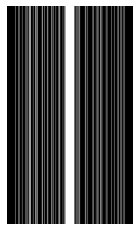

In [9]:
### load the initialization
state_url = 'https://rice.box.com/shared/static/hp8o7d1gnd4gux203vubzccuefq03qmi'
checkpoint = torch.hub.load_state_dict_from_url(state_url, progress=True)

#net.load_state_dict(checkpoint['model_state_dict'])
ni = checkpoint['net_input'].type(dtype)

# the masks are loaded from data; alternatively we can load them from the checkpoint with:
#mask, mask1d, mask2d = get_mask(slice_ksp_torchtensor, slice_ksp)

mask = checkpoint['mask']; mask1d = checkpoint['mask1d']; mask2d = checkpoint['mask2d'];

print(mask2d.shape)
print(ni.shape)
plt.imshow(mask2d,'gray')
plt.axis('off')
plt.show()

In [10]:
### fix scaling for the decoder
masked_kspace, _ = apply_mask(slice_ksp_torchtensor, mask = mask)
scaling_factor,ni = get_scale_factor(net,
                                     num_channels,
                                     in_size,
                                     masked_kspace,
                                     ni = ni,)
masked_kspace *= scaling_factor
unders_measurement = Variable(masked_kspace[None,:])

ram gorur chana 

torch.Size([1, 256, 8, 4])
1

torch.Size([1, 256, 8, 4])
2
torch.Size([1, 256, 8, 4])
3
torch.Size([1, 256, 8, 4])
4
torch.Size([1, 256, 8, 4])
5
torch.Size([1, 256, 8, 4])
6
last layer

the shape
torch.Size([1, 30, 8, 4])
7


# Fitting the un-trained network to the measurements
We fit the network's parameters so that its output passed through the forward model describes the measurements well. For this, we define the forward *model* and fit function:

### Forward model

The forward process applies the Fourier transform followed by an under-sampling mask.

In [11]:
def forwardm(img,mask):
    # img has dimension (2*num_slices, x,y)
    # output has dimension (1, num_slices, x, y, 2)
    mask = np_to_var(mask)[0].type(dtype)
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    ### re-shaping image coils
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    ### apply 2D Fourier transform
    Fimg = fft2(fimg) # dim: (1,num_slices,x,y,2)
    ### apply the mask
    for i in range(ns):
        Fimg[0,i,:,:,0] *= mask
        Fimg[0,i,:,:,1] *= mask
    return Fimg

### Optimization

The following function performs the optimization by updating the network weights with respect to the MSE loss function and the given under-sampled measurements.

In [12]:
def fit(net,              # network
        img_noisy_var,    # under-sampled measurement
        num_channels,     # number of channles in each layer (it's a list containing #channels for all layers)
        net_input,        # network input
        apply_f,          # forwrd model
        mask,             # under-sampling mask
        num_iter = 5000,  # number of gradient iterations
        LR = 0.01,        # stepsize
       ):
    
    net_input = net_input.type(dtype)
    p = [x for x in net.parameters() ]

    mse_wrt_noisy = np.zeros(num_iter)
    
    ### optimizer
    print("optimize with adam", LR)
    optimizer = torch.optim.Adam(p, lr=LR)

    ### loss function
    mse = torch.nn.MSELoss() 
    
    ### we return the best network across the iterations w.r.t fitting loss
    best_net = copy.deepcopy(net)
    best_mse = 1000000.0
        
    ### main optimization loop
    for i in range(num_iter):
        
        def closure():
            optimizer.zero_grad()
            out = net(net_input.type(dtype))
            
            # training loss 
            loss = mse( apply_f(out,mask) , img_noisy_var )
            loss.backward()
            mse_wrt_noisy[i] = loss.data.cpu().numpy()
                  
            ### display the fitting loss every 10 iterations
            if i % 10 == 0:
                print ('Iteration %05d    Train loss %f ' % (i, loss.data), '\r', end='')
            return loss   
        
        ### call the optimization step
        loss = optimizer.step(closure)
            
        # if training loss improves by at least one percent, we found a new best net
        if best_mse > 1.005*loss.data:
            best_mse = loss.data
            best_net = copy.deepcopy(net)
                 
    net = best_net
    return mse_wrt_noisy, net 

### Data consistency

Data consistency is the last step of the reconstruction. After we fit the network and get the reconstructed image, we enforce consistency by taking the frequency elements we know from the under-sampled measurement and put them in the Fourier representation of the reconstruction.


In [13]:
def data_consistency(net, ni, mask1d, slice_ksp_torchtensor1):    
    img = net(ni.type(dtype))
    s = img.shape
    ns = int(s[1]/2) # number of slices
    fimg = Variable( torch.zeros( (s[0],ns,s[2],s[3],2 ) ) ).type(dtype)
    ### get under-sampled measurement and put it in the Fourier representation of the reconstruction
    for i in range(ns):
        fimg[0,i,:,:,0] = img[0,2*i,:,:]
        fimg[0,i,:,:,1] = img[0,2*i+1,:,:]
    Fimg = fft2(fimg) # dim: (1,num_slices,x,y,2)
    # ksp has dim: (num_slices,x,y)
    meas = slice_ksp_torchtensor1.unsqueeze(0).data.cpu() # dim: (1,num_slices,x,y,2)
    mask = torch.from_numpy(np.array(mask1d, dtype=np.uint8))
    ksp_dc = Fimg.clone()
    ksp_dc = ksp_dc.detach().cpu()
    ksp_dc[:,:,:,mask==1,:] = meas[:,:,:,mask==1,:] # after data consistency block

    ### compute the inverse fourier transform of the consistency-enforced k-space
    img_dc = ifft2(ksp_dc)[0]
    out = []
    for img in img_dc.detach().cpu():
        out += [ img[:,:,0].numpy() , img[:,:,1].numpy() ]

    ### apply root sum of squares and then crop the image
    par_out_chs = np.array(out)
    par_out_imgs = channels2imgs(par_out_chs)
    prec = root_sum_of_squares(torch.from_numpy(par_out_imgs)).numpy()
    if prec.shape[0] > 320:
        prec = crop_center(prec,320,320)
    return prec

### Finally - Image recovery

We are now ready to reconstruct the image with the un-trained neural network - this runs for about 15 minutes:

In [14]:
### reconstruct ###
start = time.time()

mse_wrt_noisy, net  = fit(copy.deepcopy(net),
                          unders_measurement.type(dtype),
                          [num_channels]*(num_layers-1),
                          net_input = ni,
                          apply_f = forwardm,
                          mask = mask2d,
                          num_iter=num_iters,
                          LR=0.008,
                          )

### apply data consistency to finalize the reconstruction
rec = data_consistency(net, ni, mask1d, scaling_factor*slice_ksp_torchtensor.data.cpu())

print('\nfinished after %.1f minutes.'%((time.time()-start)/60))

optimize with adam 0.008
ram gorur chana 

torch.Size([1, 256, 8, 4])
1

torch.Size([1, 256, 8, 4])
2
torch.Size([1, 256, 8, 4])
3
torch.Size([1, 256, 8, 4])
4
torch.Size([1, 256, 8, 4])
5
torch.Size([1, 256, 8, 4])
6
last layer

the shape
torch.Size([1, 30, 8, 4])
7


RuntimeError: ignored

# Evaluating the reconstruction

Finally we evaluate our reconstruction. 

The following functions are for normalizing the output and computing the SSIM score. As shown in our paper, the choice of normalization affects the score.

In [ ]:
def normalize(im1,im2):
    # im1: ground truth
    # im2: reconstruction
    im1 = (im1-im1.mean()) / im1.std()
    im1 *= im2.std()
    im1 += im2.mean()
    return im1,im2
def ssim(gt, pred):
    """ Compute Structural Similarity Index Metric (SSIM). """
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [ ]:
### evaluate the reconstruction quality
im1,im2 = normalize(orig,rec)
score = ssim(np.array([im1]),np.array([im2]))

In [ ]:
### Visualize the output ###
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(121)
ax.imshow(orig,'gray')
ax.set_title(filename.split('/')[-1])
ax.axis('off')

ax = fig.add_subplot(122)
ax.imshow(rec,'gray')
ax.set_title('SSIM: %.4f'%(score))
ax.axis('off')
plt.show()